                                                 url    type
0  epinions.com/review/Mahogany_Soul_by_Angie_Sto...  benign
1                 shokolat2.blogfa.com/post-123.aspx  benign
2              snc-lavalin.com/expertise.php?lang=en  benign
3  http://ap.org/Content/AP-In-The-News/2012/In-t...  benign
4                rcnvr.com/F%20-%20RCN%20-%20WW2.php  benign


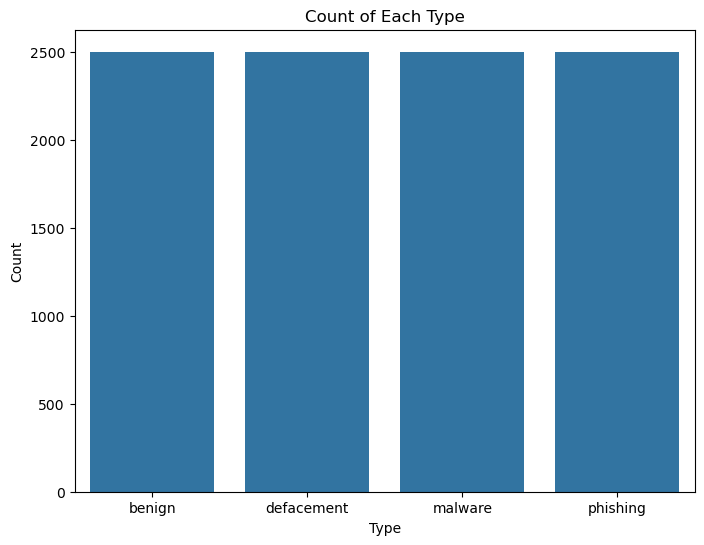

Class Distribution:
 type
benign        2500
defacement    2500
malware       2500
phishing      2500
Name: count, dtype: int64
Unique classes in training data: ['benign' 'defacement' 'malware' 'phishing']
Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
SVM (rbf Kernel) Accuracy with DRLSH-selected features: 0.7445000
Precision: 0.7584514
Recall: 0.7445000
F1 Score: 0.7456573
Training Time: 5.1876 seconds
              precision    recall  f1-score   support

      benign       0.63      0.73      0.67       500
  defacement       0.72      0.85      0.78       500
     malware       0.95      0.80      0.87       500
    phishing       0.74      0.60      0.66       500

    accuracy                           0.74      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.76      0.74      0.75      2000

Model saved successfully.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
import time
import pickle

# Load the dataset
df = pd.read_csv('balanced_malicious_phish.csv')

# Handle missing values by dropping rows with NaN values
df = df.dropna()

# Display the first few rows of the dataset
print(df.head())

# Plot the count of each type
plt.figure(figsize=(8, 6))
sns.countplot(x="type", data=df)
plt.title("Count of Each Type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

def extract_features(url):
    features = {}
    features['url_length'] = len(url)
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['num_letters'] = sum(c.isalpha() for c in url)
    features['num_special_chars'] = sum(not c.isalnum() for c in url)
    features['num_subdomains'] = url.count('.')
    features['num_query_params'] = url.count('?')
    return features

# Apply feature extraction to the dataset
features = df['url'].apply(lambda x: extract_features(str(x)))
features_df = pd.DataFrame(list(features))

# Combine features with the target variable
df = pd.concat([features_df, df['type']], axis=1)

# Check the distribution of classes in the target variable
class_distribution = pd.Series(df['type']).value_counts()
print("Class Distribution:\n", class_distribution)

# Remove classes with fewer than 2 instances
min_samples = 2
classes_to_keep = class_distribution[class_distribution >= min_samples].index
df_filtered = df[df['type'].isin(classes_to_keep)]

# Redefine X and y after filtering
X = df_filtered[['url_length', 'num_digits', 'num_letters', 'num_special_chars', 'num_subdomains', 'num_query_params']].values
y = df_filtered['type'].values

# Ensure no NaN values in X and y
X = np.nan_to_num(X)  # Replace NaN with 0 in features
y = pd.Series(y).fillna('unknown')  # Replace NaN with 'unknown' in target variable

# Split the data using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check unique classes in training data
unique_classes = np.unique(y_train)
print("Unique classes in training data:", unique_classes)

# Calculate class weights manually
class_weights = {label: 1.0 for label in unique_classes}
# Adjust class weights if necessary (optional, based on class distribution)

# Define the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=class_weights)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Train the best model and calculate training time
start_time = time.time()  # Start the timer
best_model.fit(X_train, y_train)
training_time = time.time() - start_time  # Calculate training time

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate performance metrics
svm_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Output the metrics
print(f"SVM (rbf Kernel) Accuracy with DRLSH-selected features: {svm_accuracy:.7f}")
print(f"Precision: {precision:.7f}")
print(f"Recall: {recall:.7f}")
print(f"F1 Score: {f1:.7f}")
print(f"Training Time: {training_time:.4f} seconds")

# Output classification report
print(classification_report(y_test, y_pred))

# Save the trained model
with open('svm_drlsh.pkl', 'wb') as file:
    pickle.dump(best_model, file)
f
print("Model saved successfully.")
